# Transfer Learning et Fine-Tuning avec BERT : Classification de Sentiments

## Objectifs de ce notebook

Dans ce notebook, nous allons explorer le **Transfer Learning** et le **Fine-Tuning** en NLP avec l'architecture **BERT** :

1. **Classification baseline avec LSTM** - L'approche traditionnelle
2. **Comprendre BERT** - Architecture et pré-entraînement
3. **Transfer Learning** - Utiliser un modèle pré-entraîné
4. **Fine-Tuning** - Adapter BERT à notre tâche spécifique

Nous utiliserons le célèbre dataset **IMDB Movie Reviews** pour la classification de sentiments (positif/négatif).

## Pourquoi le Transfer Learning ?

Le Transfer Learning a révolutionné le NLP en 2018-2019 :
- **Pré-entraînement massif** sur des milliards de mots
- **Fine-tuning rapide** sur votre tâche spécifique (quelques heures au lieu de semaines)
- **Performances SOTA** même avec peu de données annotées
- **Économie de ressources** - pas besoin d'entraîner from scratch

## 📚 Concepts clés que nous allons explorer

- **Pre-training** : Entraînement non supervisé sur un corpus massif
- **Fine-tuning** : Adaptation supervisée à une tâche spécifique
- **Feature Extraction** : Utiliser BERT comme extracteur de features
- **Layer Freezing** : Geler certaines couches pour le transfer learning
- **Learning Rate Scheduling** : Stratégies d'optimisation pour le fine-tuning

## 🔧 Note sur la Compatibilité Keras 3

Ce notebook utilise **KerasNLP**, la bibliothèque officielle de Keras pour le NLP, qui est **nativement compatible avec Keras 3**.

## 1. Imports et Configuration

In [ ]:
# Bibliothèques principales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output, HTML
import warnings
warnings.filterwarnings('ignore')

# TensorFlow et Keras
import tensorflow as tf
import keras
from keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

# KerasNLP pour BERT
import keras_nlp

# Sklearn pour métriques
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Configuration GPU
try:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU(s) détecté(s): {len(gpus)} - Croissance mémoire activée")
    else:
        print("⚠️  Aucun GPU détecté - Utilisation du CPU")
except Exception as e:
    print(f"Configuration GPU: {e}")

# Configuration graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Reproductibilité
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
keras.utils.set_random_seed(SEED)

print(f"\n📦 TensorFlow version: {tf.__version__}")
print(f"📦 Keras version: {keras.__version__}")
print(f"📦 KerasNLP version: {keras_nlp.__version__}")

✅ GPU(s) détecté(s): 1 - Croissance mémoire activée

📦 TensorFlow version: 2.19.1
📦 Keras version: 3.11.3
📦 KerasNLP version: 0.23.0


## Méthodes utiles

In [ ]:
def column_summary(df: pd.DataFrame):
    summary = []
    for col in df.columns:
        col_type = df[col].dtype
        non_null = df[col].notna().sum()
        null_count = df[col].isna().sum()
        
        # Gérer le cas où la colonne contient des listes (unhashable)
        try:
            unique_count = df[col].nunique()
        except TypeError:
            # Si erreur (listes), convertir en string temporairement
            unique_count = df[col].astype(str).nunique()
            print(f"⚠️ Colonne '{col}' contient des types non-hashable (probablement des listes)")

        summary.append({
            'Column': col,
            'Type': str(col_type),
            'Non-Null Count': non_null,
            'Null Count': null_count,
            'Unique Values': unique_count,
        })

    # Afficher le résumé des colonnes
    print("=" * 80)
    print("Résumé détaillé des colonnes:")
    print("=" * 80)
    column_summary_df = pd.DataFrame(summary)
    print(column_summary_df.to_string(index=False))
    print("\n")

## 2. Chargement et Exploration du Dataset IMDB

Le dataset IMDB contient 50,000 reviews de films annotées :
- **25,000 pour l'entraînement** (12,500 positifs, 12,500 négatifs)
- **25,000 pour le test** (12,500 positifs, 12,500 négatifs)
- Dataset parfaitement équilibré

In [28]:
# Charger le dataset IMDB depuis Keras
print("📥 Téléchargement du dataset IMDB...\n")

# Charger directement le dataset texte
(X_train_raw, y_train_raw), (X_test_raw, y_test_raw) = keras.datasets.imdb.load_data()

# Récupérer le dictionnaire mot -> index
word_index = keras.datasets.imdb.get_word_index()

# Créer l'index inverse
reverse_word_index = {value: key for key, value in word_index.items()}

def decode_review(encoded_review):
    """Décode une review encodée en texte."""
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in encoded_review])

print(f"📊 Statistiques du Dataset IMDB")
print("=" * 60)
print(f"\nNombre de reviews d'entraînement: {len(X_train_raw):,}")
print(f"Nombre de reviews de test: {len(X_test_raw):,}")
print(f"\nRépartition des classes (train):")
print(f"  Positif (1): {np.sum(y_train_raw == 1):,} ({np.mean(y_train_raw == 1)*100:.1f}%)")
print(f"  Négatif (0): {np.sum(y_train_raw == 0):,} ({np.mean(y_train_raw == 0)*100:.1f}%)")

📥 Téléchargement du dataset IMDB...

📊 Statistiques du Dataset IMDB

Nombre de reviews d'entraînement: 25,000
Nombre de reviews de test: 25,000

Répartition des classes (train):
  Positif (1): 12,500 (50.0%)
  Négatif (0): 12,500 (50.0%)


In [ ]:
column_summary()

In [29]:
# Convertir en texte et limiter pour la démo
SUBSET_SIZE = 25000  # Utiliser 5000 reviews pour démo

print(f"🔄 Conversion en texte et extraction d'un sous-ensemble...\n")

# Décoder toutes les reviews
X_train_all_text = [decode_review(review) for review in X_train_raw[:SUBSET_SIZE]]
y_train_all = y_train_raw[:SUBSET_SIZE]

X_test_all_text = [decode_review(review) for review in X_test_raw[:SUBSET_SIZE//2]]
y_test_all = y_test_raw[:SUBSET_SIZE//2]

# Créer un validation set
X_train_text, X_val_text, y_train, y_val = train_test_split(
    X_train_all_text, y_train_all, test_size=0.2, random_state=SEED, stratify=y_train_all
)

X_test_text = X_test_all_text
y_test = y_test_all

print(f"✅ Préparation terminée !")
print(f"\n📊 Répartition finale:")
print(f"   Train: {len(X_train_text):,} reviews")
print(f"   Validation: {len(X_val_text):,} reviews")
print(f"   Test: {len(X_test_text):,} reviews")

# Statistiques de longueur
train_lengths = [len(text.split()) for text in X_train_text]
print(f"\n📏 Longueur moyenne des reviews: {np.mean(train_lengths):.0f} mots")

🔄 Conversion en texte et extraction d'un sous-ensemble...

✅ Préparation terminée !

📊 Répartition finale:
   Train: 20,000 reviews
   Validation: 5,000 reviews
   Test: 12,500 reviews

📏 Longueur moyenne des reviews: 238 mots


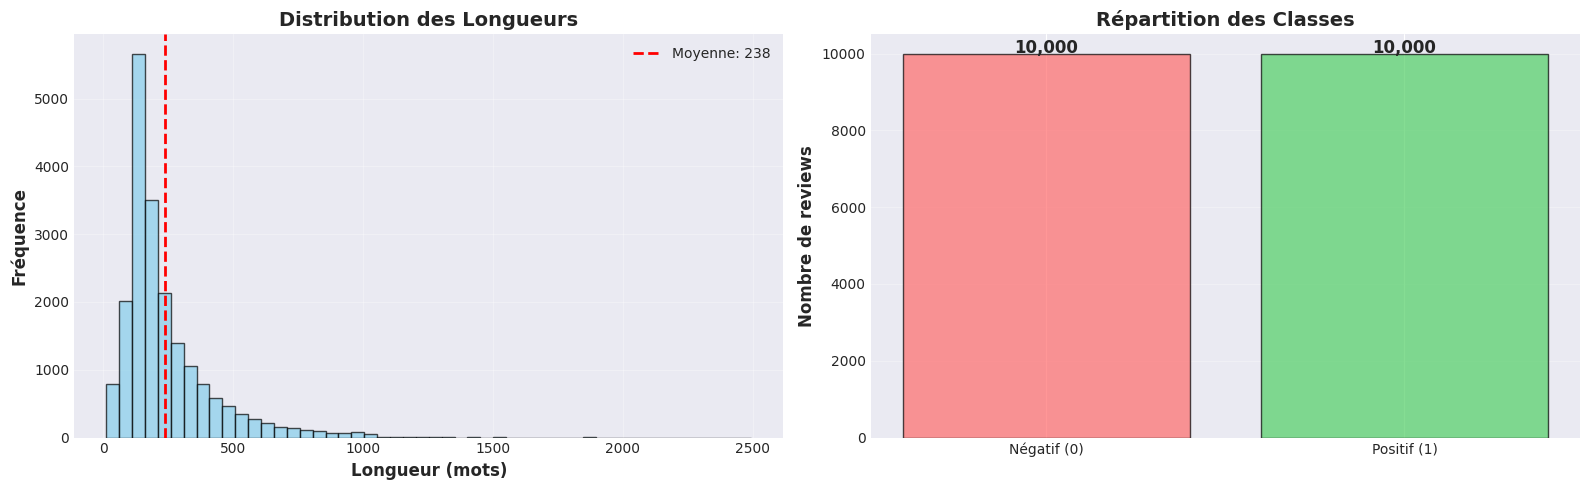

In [30]:
# Visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Distribution des longueurs
ax1.hist(train_lengths, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
ax1.axvline(np.mean(train_lengths), color='red', linestyle='--', linewidth=2, 
            label=f'Moyenne: {np.mean(train_lengths):.0f}')
ax1.set_xlabel('Longueur (mots)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Fréquence', fontsize=12, fontweight='bold')
ax1.set_title('Distribution des Longueurs', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Distribution des classes
labels = ['Négatif (0)', 'Positif (1)']
counts = [np.sum(y_train == 0), np.sum(y_train == 1)]
colors = ['#ff6b6b', '#51cf66']

ax2.bar(labels, counts, color=colors, edgecolor='black', alpha=0.7)
ax2.set_ylabel('Nombre de reviews', fontsize=12, fontweight='bold')
ax2.set_title('Répartition des Classes', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3, axis='y')

for i, (label, count) in enumerate(zip(labels, counts)):
    ax2.text(i, count + 20, f'{count:,}', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

### 2.1 Exemples de Reviews

In [31]:
# Afficher des exemples
print("\n" + "=" * 80)
print(" " * 25 + "📝 EXEMPLES DE REVIEWS")
print("=" * 80)

pos_indices = np.where(y_train == 1)[0][:2]
neg_indices = np.where(y_train == 0)[0][:2]

for idx in list(pos_indices) + list(neg_indices):
    review = X_train_text[idx]
    sentiment = "✅ POSITIF" if y_train[idx] == 1 else "❌ NÉGATIF"
    
    print(f"\n{sentiment}")
    print("-" * 80)
    print(review[:500] + "..." if len(review) > 500 else review)
    print(f"\nLongueur: {len(review.split())} mots")


                         📝 EXEMPLES DE REVIEWS

✅ POSITIF
--------------------------------------------------------------------------------
? sorry to say i have no idea what hollywood is doing sure give us movies like batman begins oh by the way hollywood i think they may cover the story line in the movie batman but please don't entertain us what we would really want to see batman and superman together i really hated this trailer because it left me wanting for more i was looking around to see when it was coming out it was like a terrible practical joke the graphics where good the story line seemed solid and it had all the trappings...

Longueur: 133 mots

✅ POSITIF
--------------------------------------------------------------------------------
? this unassuming fairly routine series deserves credit in the tv history books for two reasons it was the first to win an emmy award for best syndicated series and it was the very first show to come from the fabled studios of republic pictures

## 3. Modèle Baseline : LSTM

### 3.1 Tokenization pour LSTM

In [32]:
# Configuration
MAX_WORDS = 10000
MAX_LEN = 200

# Tokenizer
tokenizer_lstm = Tokenizer(num_words=MAX_WORDS, oov_token='<UNK>')
tokenizer_lstm.fit_on_texts(X_train_text)

# Séquences
X_train_seq = tokenizer_lstm.texts_to_sequences(X_train_text)
X_val_seq = tokenizer_lstm.texts_to_sequences(X_val_text)
X_test_seq = tokenizer_lstm.texts_to_sequences(X_test_text)

# Padding
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post')

print(f"✅ Tokenization terminée !")
print(f"\n📐 Shapes: Train {X_train_pad.shape}, Val {X_val_pad.shape}, Test {X_test_pad.shape}")

✅ Tokenization terminée !

📐 Shapes: Train (20000, 200), Val (5000, 200), Test (12500, 200)


### 3.2 Architecture et Entraînement LSTM

In [33]:
def creer_modele_lstm(vocab_size, embedding_dim=128, lstm_units=64):
    model = models.Sequential([
        layers.Embedding(vocab_size, embedding_dim, input_length=MAX_LEN),
        layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True)),
        layers.Dropout(0.3),
        layers.Bidirectional(layers.LSTM(lstm_units)),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

lstm_model = creer_modele_lstm(MAX_WORDS)
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("🔨 Modèle LSTM créé !\n")
lstm_model.summary()

🔨 Modèle LSTM créé !



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Entraînement
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print("🚀 Entraînement LSTM...\n")
history_lstm = lstm_model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

print("\n✅ Entraînement LSTM terminé !")

🚀 Entraînement LSTM...

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - accuracy: 0.7081 - loss: 0.5695 - val_accuracy: 0.7710 - val_loss: 0.5038
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - accuracy: 0.8501 - loss: 0.3698 - val_accuracy: 0.8392 - val_loss: 0.3919
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - accuracy: 0.9043 - loss: 0.2493 - val_accuracy: 0.8554 - val_loss: 0.3829
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.9385 - loss: 0.1703 - val_accuracy: 0.8602 - val_loss: 0.4206
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - accuracy: 0.9563 - loss: 0.1279 - val_accuracy: 0.8564 - val_loss: 0.4279
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 53ms/step - accuracy: 0.9298 - loss: 0.1842 - val_accuracy: 0.8452 - val_loss: 0.5053

✅ Entraînement LSTM terminé !


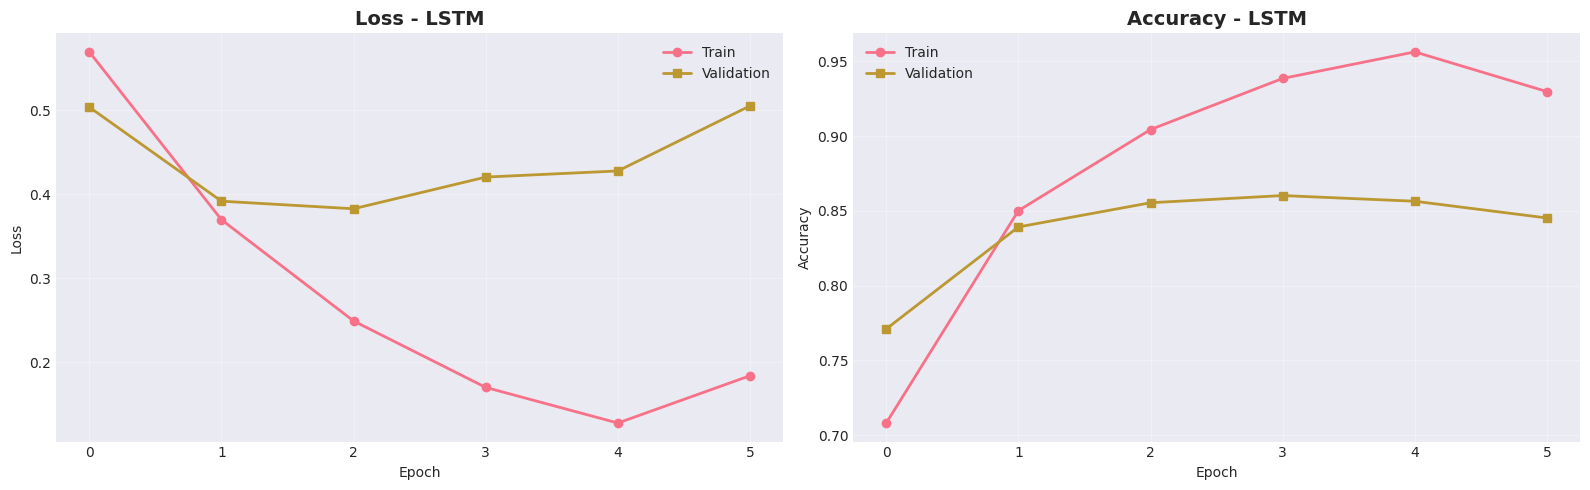

In [35]:
# Visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ax1.plot(history_lstm.history['loss'], label='Train', linewidth=2, marker='o')
ax1.plot(history_lstm.history['val_loss'], label='Validation', linewidth=2, marker='s')
ax1.set_title('Loss - LSTM', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

ax2.plot(history_lstm.history['accuracy'], label='Train', linewidth=2, marker='o')
ax2.plot(history_lstm.history['val_accuracy'], label='Validation', linewidth=2, marker='s')
ax2.set_title('Accuracy - LSTM', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 3.3 Évaluation LSTM

In [36]:
# Évaluation
test_loss, test_acc = lstm_model.evaluate(X_test_pad, y_test, verbose=0)
y_pred_lstm = (lstm_model.predict(X_test_pad, verbose=0) > 0.5).astype(int).flatten()

print("\n📊 PERFORMANCES LSTM")
print("=" * 60)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print("\n📈 Classification Report:")
print(classification_report(y_test, y_pred_lstm, target_names=['Négatif', 'Positif']))


📊 PERFORMANCES LSTM
Test Loss: 0.3958
Test Accuracy: 0.8529 (85.29%)

📈 Classification Report:
              precision    recall  f1-score   support

     Négatif       0.86      0.85      0.85      6316
     Positif       0.85      0.85      0.85      6184

    accuracy                           0.85     12500
   macro avg       0.85      0.85      0.85     12500
weighted avg       0.85      0.85      0.85     12500



## 4. BERT avec KerasNLP

### 4.1 Introduction à KerasNLP

**KerasNLP** est la bibliothèque officielle de Keras pour le NLP :
- ✅ Nativement compatible avec Keras 3
- ✅ API simple et cohérente
- ✅ Preprocessing intégré
- ✅ Modèles pré-entraînés (BERT, GPT, etc.)
- ✅ Optimisé pour les performances

In [37]:
# Architecture BERT
bert_info_html = """
<div style="font-family: Arial; padding: 20px; background-color: #f5f5f5; border-radius: 10px;">
    <h3 style="text-align: center; color: #2c3e50;">🏗️ BERT avec KerasNLP</h3>
    
    <div style="background: white; padding: 15px; margin: 10px 0; border-left: 4px solid #3498db;">
        <strong>BERT (Bidirectional Encoder Representations from Transformers)</strong>
        <ul>
            <li>Pré-entraîné sur Wikipedia + BookCorpus (3.3B mots)</li>
            <li>12 couches Transformer</li>
            <li>768 dimensions</li>
            <li>110M paramètres</li>
        </ul>
    </div>
    
    <div style="background: white; padding: 15px; margin: 10px 0; border-left: 4px solid #2ecc71;">
        <strong>KerasNLP : Pourquoi c'est mieux ?</strong>
        <ul>
            <li>✅ API unifiée et simple</li>
            <li>✅ Compatible Keras 3 nativement</li>
            <li>✅ Preprocessing automatique</li>
            <li>✅ Optimisé pour la performance</li>
        </ul>
    </div>
</div>
"""

display(HTML(bert_info_html))

### 4.2 Préparation des Données pour BERT

In [38]:
# Charger le préprocesseur BERT de KerasNLP
print("📥 Chargement du preprocesseur BERT...\n")

# Utiliser le preprocesseur BERT pré-entraîné
preprocessor = keras_nlp.models.BertPreprocessor.from_preset(
    "bert_small_en_uncased",  # Version légère pour la démo
    sequence_length=128
)

print("✅ Preprocesseur chargé !")
print(f"\nVocabulaire: {preprocessor.tokenizer.vocabulary_size():,} tokens")
print(f"Longueur de séquence: 128")

📥 Chargement du preprocesseur BERT...

✅ Preprocesseur chargé !

Vocabulaire: 30,522 tokens
Longueur de séquence: 128


In [39]:
# Test du preprocesseur
test_text = "This movie was absolutely fantastic!"
preprocessed = preprocessor([test_text])

print(f"\n🔍 Test du preprocesseur:")
print(f"\nTexte original: '{test_text}'")
print(f"\nClés disponibles: {list(preprocessed.keys())}")
print(f"\ntoken_ids shape: {preprocessed['token_ids'].shape}")
print(f"segment_ids shape: {preprocessed['segment_ids'].shape}")
print(f"padding_mask shape: {preprocessed['padding_mask'].shape}")


🔍 Test du preprocesseur:

Texte original: 'This movie was absolutely fantastic!'

Clés disponibles: ['token_ids', 'padding_mask', 'segment_ids']

token_ids shape: (1, 128)
segment_ids shape: (1, 128)
padding_mask shape: (1, 128)


## 5. Fine-Tuning BERT

### 5.1 Approche 1 : Feature Extraction (BERT Gelé)

In [40]:
def creer_modele_bert_frozen():
    """
    Crée un modèle BERT avec les poids gelés (Feature Extraction).
    """
    # Charger BERT pré-entraîné
    bert_backbone = keras_nlp.models.BertBackbone.from_preset(
        "bert_small_en_uncased",  # Version légère
        trainable=False  # GELÉ
    )
    
    # Input
    inputs = {
        "token_ids": layers.Input(shape=(128,), dtype=tf.int32, name="token_ids"),
        "segment_ids": layers.Input(shape=(128,), dtype=tf.int32, name="segment_ids"),
        "padding_mask": layers.Input(shape=(128,), dtype=tf.int32, name="padding_mask"),
    }
    
    # BERT Encoder
    bert_output = bert_backbone(inputs)["sequence_output"]
    
    # Prendre le [CLS] token (première position)
    cls_token = bert_output[:, 0, :]
    
    # Couches de classification
    x = layers.Dropout(0.3)(cls_token)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(1, activation='sigmoid', name='classifier')(x)
    
    model = keras.Model(inputs, output)
    
    return model, bert_backbone

# Créer le modèle
print("🔨 Création du modèle BERT (Feature Extraction)...\n")
bert_frozen_model, bert_backbone = creer_modele_bert_frozen()

# Compiler
bert_frozen_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("✅ Modèle BERT (frozen) créé !\n")
bert_frozen_model.summary()

🔨 Création du modèle BERT (Feature Extraction)...

✅ Modèle BERT (frozen) créé !



Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ padding_mask        │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segment_ids         │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_backbone       │ [(None, 512),     │ 28,763,648 │ padding_mask[0][… │
│ (BertBackbone)      │ (None, 128, 512)] │            │ segment_ids[0][0… │
│                     │                   │            │ token_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 512)       │          0 │ bert_backbone[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 512)       │          0 │ get_item_5[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │     32,832 │ dropout_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 64)        │          0 │ dense_7[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier (Dense)  │ (None, 1)         │         65 │ dropout_21[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 28,796,545 (109.85 MB)

 Trainable params: 32,897 (128.50 KB)

 Non-trainable params: 28,763,648 (109.72 MB)

In [41]:
# Préprocesser les données
print("🔄 Preprocessing des données avec BERT...\n")

X_train_bert = preprocessor(X_train_text)
X_val_bert = preprocessor(X_val_text)
X_test_bert = preprocessor(X_test_text)

print("✅ Preprocessing terminé !")

🔄 Preprocessing des données avec BERT...

✅ Preprocessing terminé !


In [42]:
# Entraînement
print("\n🚀 Entraînement BERT (Feature Extraction)...\n")

history_bert_frozen = bert_frozen_model.fit(
    X_train_bert,
    y_train,
    validation_data=(X_val_bert, y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)

print("\n✅ Entraînement BERT (frozen) terminé !")


🚀 Entraînement BERT (Feature Extraction)...

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.6985 - loss: 0.5772 - val_accuracy: 0.7546 - val_loss: 0.5075
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7321 - loss: 0.5339 - val_accuracy: 0.7660 - val_loss: 0.4983
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7343 - loss: 0.5306 - val_accuracy: 0.7614 - val_loss: 0.4924
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7372 - loss: 0.5241 - val_accuracy: 0.7616 - val_loss: 0.4939
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7378 - loss: 0.5231 - val_accuracy: 0.7664 - val_loss: 0.4889
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7418 - loss: 0.5177 - val_accuracy: 0.7582 - val_loss: 0.4866
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7399 - loss: 0.5220 - val_accuracy: 0.7674 - val_loss: 0.4848
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - a

### 5.2 Approche 2 : Fine-Tuning Complet

In [43]:
def creer_modele_bert_finetuned():
    """
    Crée un modèle BERT avec fine-tuning complet.
    """
    # BERT backbone - TOUS LES POIDS ENTRAÎNABLES
    bert_backbone = keras_nlp.models.BertBackbone.from_preset(
        "bert_tiny_en_uncased",
        trainable=True  # FINE-TUNING
    )
    
    # Inputs
    inputs = {
        "token_ids": layers.Input(shape=(128,), dtype=tf.int32, name="token_ids"),
        "segment_ids": layers.Input(shape=(128,), dtype=tf.int32, name="segment_ids"),
        "padding_mask": layers.Input(shape=(128,), dtype=tf.int32, name="padding_mask"),
    }
    
    # BERT
    bert_output = bert_backbone(inputs)["sequence_output"]
    cls_token = bert_output[:, 0, :]
    
    # Classification
    x = layers.Dropout(0.3)(cls_token)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs, output)
    
    return model

# Créer le modèle
print("🔨 Création du modèle BERT (Fine-Tuning)...\n")
bert_finetuned_model = creer_modele_bert_finetuned()

# Compiler avec LR très bas
bert_finetuned_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=2e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("✅ Modèle BERT (fine-tuning) créé !")

🔨 Création du modèle BERT (Fine-Tuning)...

✅ Modèle BERT (fine-tuning) créé !


In [44]:
# Callbacks
early_stop_bert = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-7)

# Entraînement
print("\n🚀 Fine-Tuning BERT...\n")

history_bert_finetuned = bert_finetuned_model.fit(
    X_train_bert,
    y_train,
    validation_data=(X_val_bert, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop_bert, reduce_lr],
    verbose=1
)

print("\n✅ Fine-Tuning BERT terminé !")


🚀 Fine-Tuning BERT...

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.5757 - loss: 0.7023 - val_accuracy: 0.6820 - val_loss: 0.6096 - learning_rate: 2.0000e-05
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7116 - loss: 0.5627 - val_accuracy: 0.7802 - val_loss: 0.4653 - learning_rate: 2.0000e-05
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7818 - loss: 0.4624 - val_accuracy: 0.7964 - val_loss: 0.4372 - learning_rate: 2.0000e-05
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8069 - loss: 0.4262 - val_accuracy: 0.8130 - val_loss: 0.4146 - learning_rate: 2.0000e-05
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8250 - loss: 0.3959 - val_accuracy: 0.8180 - val_loss: 0.4054 - learning_rate: 2.0000e-05
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8431 - loss: 0.3612 - val_accuracy: 0.8210 - val_loss: 0.4013 - learning_rate: 2.0000e-05
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━

## 6. Comparaison des Modèles

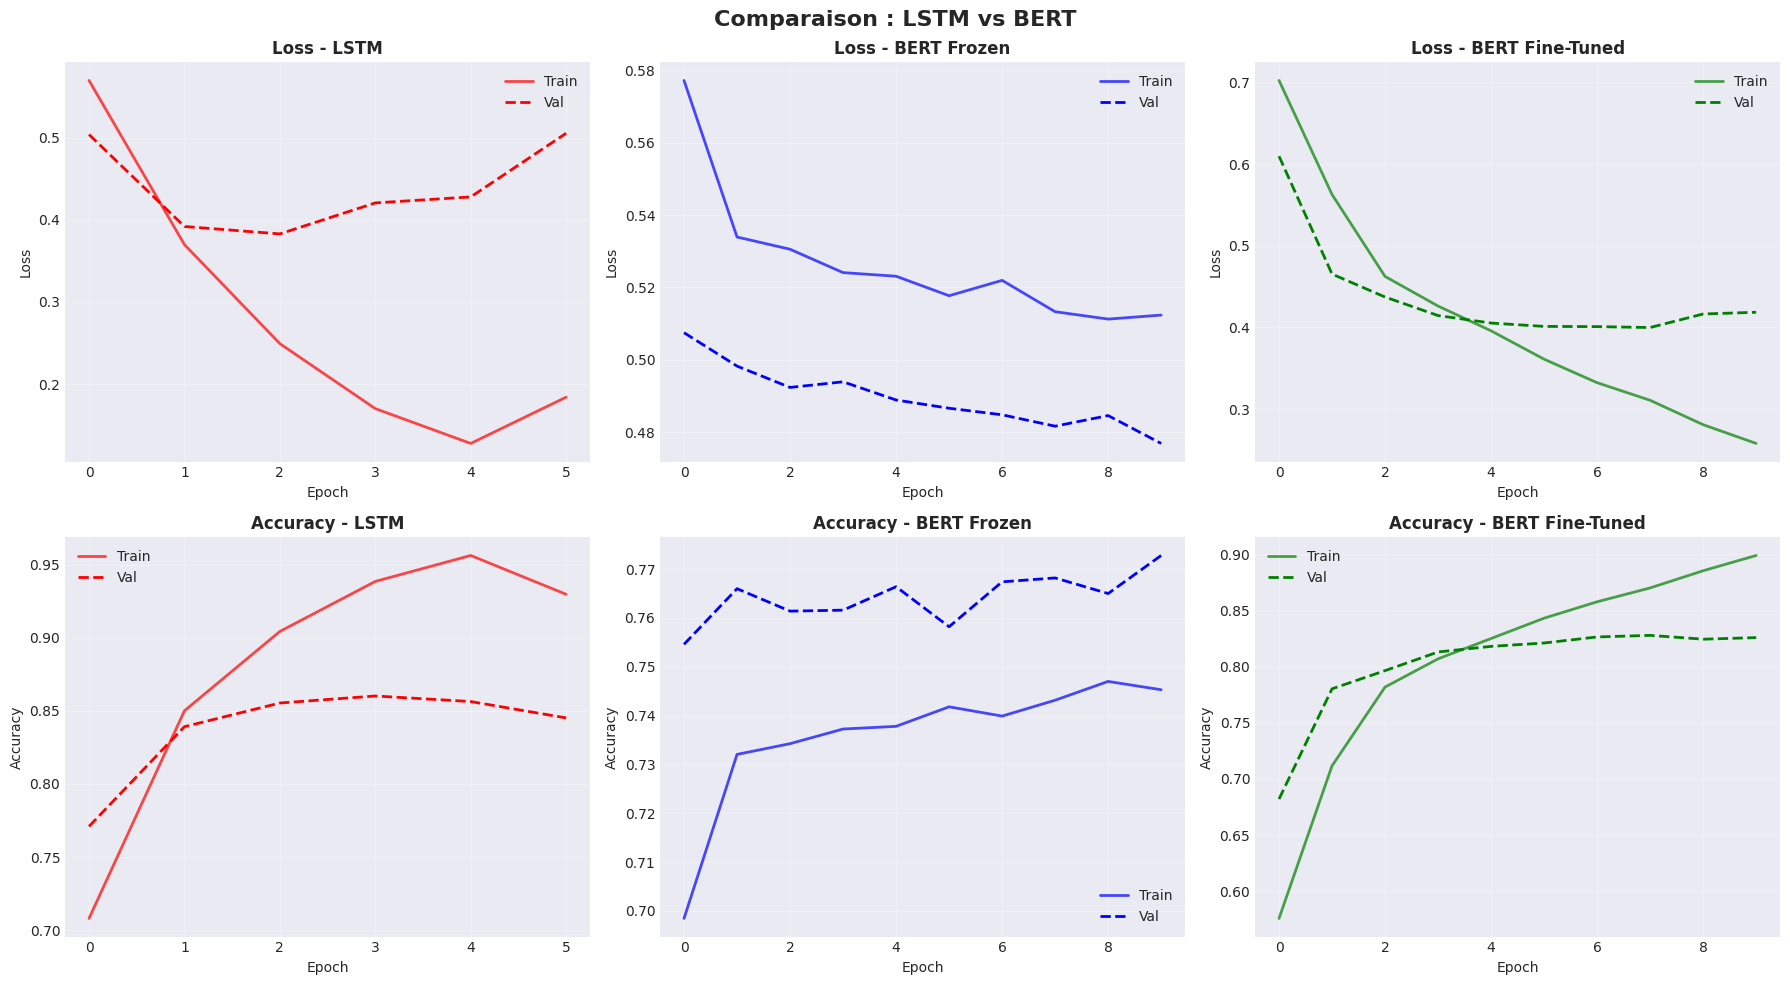

In [45]:
# Visualisation comparative
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Comparaison : LSTM vs BERT', fontsize=16, fontweight='bold')

models_histories = [
    ('LSTM', history_lstm, 'red'),
    ('BERT Frozen', history_bert_frozen, 'blue'),
    ('BERT Fine-Tuned', history_bert_finetuned, 'green')
]

# Loss
for idx, (name, history, color) in enumerate(models_histories):
    ax = axes[0, idx]
    ax.plot(history.history['loss'], label='Train', linewidth=2, color=color, alpha=0.7)
    ax.plot(history.history['val_loss'], label='Val', linewidth=2, color=color, linestyle='--')
    ax.set_title(f'Loss - {name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(alpha=0.3)

# Accuracy
for idx, (name, history, color) in enumerate(models_histories):
    ax = axes[1, idx]
    ax.plot(history.history['accuracy'], label='Train', linewidth=2, color=color, alpha=0.7)
    ax.plot(history.history['val_accuracy'], label='Val', linewidth=2, color=color, linestyle='--')
    ax.set_title(f'Accuracy - {name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 6.1 Évaluation Finale

In [46]:
# Évaluer tous les modèles
print("\n" + "=" * 80)
print(" " * 20 + "📊 PERFORMANCES FINALES")
print("=" * 80)

# LSTM
lstm_test_loss, lstm_test_acc = lstm_model.evaluate(X_test_pad, y_test, verbose=0)
y_pred_lstm = (lstm_model.predict(X_test_pad, verbose=0) > 0.5).astype(int).flatten()

# BERT Frozen
bert_frozen_test_loss, bert_frozen_test_acc = bert_frozen_model.evaluate(X_test_bert, y_test, verbose=0)
y_pred_bert_frozen = (bert_frozen_model.predict(X_test_bert, verbose=0) > 0.5).astype(int).flatten()

# BERT Fine-Tuned
bert_ft_test_loss, bert_ft_test_acc = bert_finetuned_model.evaluate(X_test_bert, y_test, verbose=0)
y_pred_bert_ft = (bert_finetuned_model.predict(X_test_bert, verbose=0) > 0.5).astype(int).flatten()

# Tableau comparatif
results_df = pd.DataFrame({
    'Modèle': ['LSTM', 'BERT Frozen', 'BERT Fine-Tuned'],
    'Test Loss': [lstm_test_loss, bert_frozen_test_loss, bert_ft_test_loss],
    'Test Accuracy': [lstm_test_acc, bert_frozen_test_acc, bert_ft_test_acc],
    'Amélioration vs LSTM': [
        '0.00%',
        f'+{(bert_frozen_test_acc - lstm_test_acc)*100:.2f}%',
        f'+{(bert_ft_test_acc - lstm_test_acc)*100:.2f}%'
    ]
})

print("\n")
print(results_df.to_string(index=False))
print("\n" + "=" * 80)

best_idx = results_df['Test Accuracy'].idxmax()
print(f"\n🏆 MEILLEUR: {results_df.loc[best_idx, 'Modèle']} - {results_df.loc[best_idx, 'Test Accuracy']*100:.2f}%")


                    📊 PERFORMANCES FINALES


         Modèle  Test Loss  Test Accuracy Amélioration vs LSTM
           LSTM   0.395846        0.85288                0.00%
    BERT Frozen   0.472310        0.77576              +-7.71%
BERT Fine-Tuned   0.398562        0.82072              +-3.22%


🏆 MEILLEUR: LSTM - 85.29%


### 6.2 Matrices de Confusion

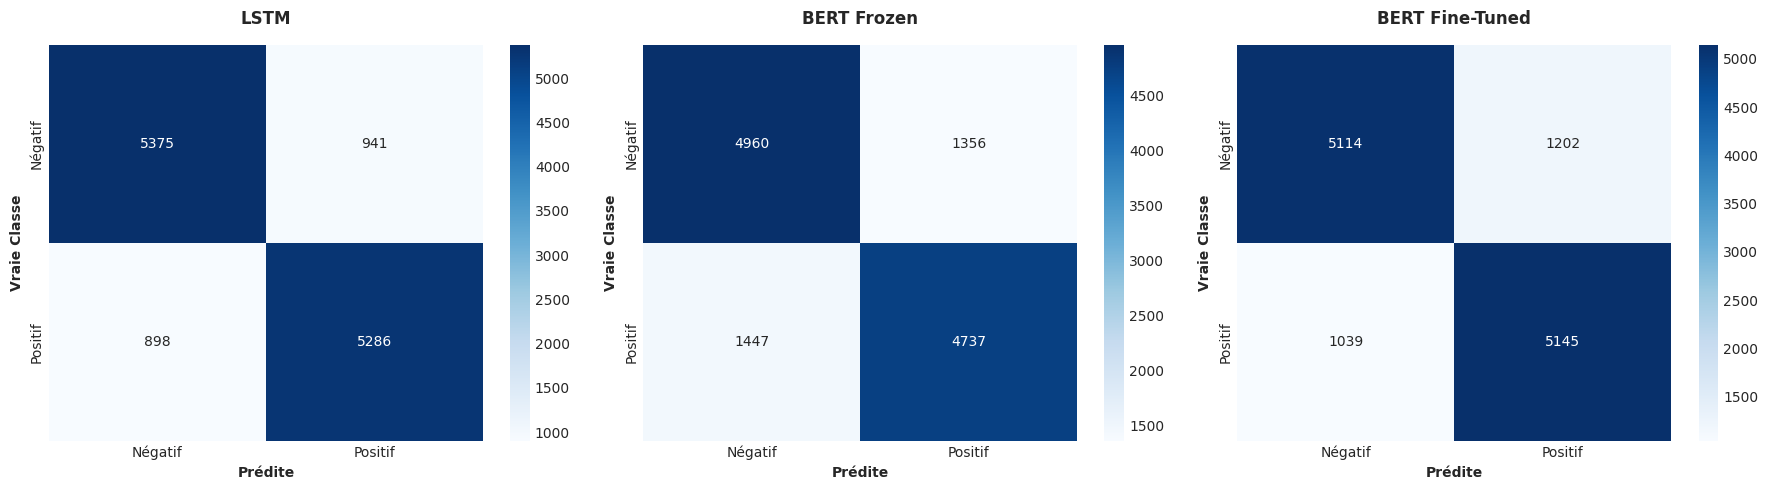

In [47]:
# Matrices de confusion
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

predictions = [
    ('LSTM', y_pred_lstm),
    ('BERT Frozen', y_pred_bert_frozen),
    ('BERT Fine-Tuned', y_pred_bert_ft)
]

for idx, (name, y_pred) in enumerate(predictions):
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Négatif', 'Positif'],
                yticklabels=['Négatif', 'Positif'])
    
    axes[idx].set_title(f'{name}', fontsize=12, fontweight='bold', pad=15)
    axes[idx].set_ylabel('Vraie Classe', fontweight='bold')
    axes[idx].set_xlabel('Prédite', fontweight='bold')

plt.tight_layout()
plt.show()

In [48]:
# Reports détaillés
print("\n📈 CLASSIFICATION REPORTS\n")
for name, y_pred in predictions:
    print(f"\n{name}:")
    print("-" * 80)
    print(classification_report(y_test, y_pred, target_names=['Négatif', 'Positif']))


📈 CLASSIFICATION REPORTS


LSTM:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

     Négatif       0.86      0.85      0.85      6316
     Positif       0.85      0.85      0.85      6184

    accuracy                           0.85     12500
   macro avg       0.85      0.85      0.85     12500
weighted avg       0.85      0.85      0.85     12500


BERT Frozen:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

     Négatif       0.77      0.79      0.78      6316
     Positif       0.78      0.77      0.77      6184

    accuracy                           0.78     12500
   macro avg       0.78      0.78      0.78     12500
weighted avg       0.78      0.78      0.78     12500


BERT Fine-Tuned:
--------------------------------------------------------------------------------
              precision    recall  f1

## 7. Tests sur Nouvelles Reviews

In [49]:
# Reviews de test
test_reviews = [
    "This movie was absolutely amazing! The acting was superb.",
    "Terrible film. Waste of time and money. The worst movie ever.",
    "It was okay, nothing special. Some good moments but forgettable.",
    "Brilliant masterpiece! One of the best films of the decade!",
    "Boring and predictable. The actors tried but the script was awful.",
    "I loved every minute! The cinematography was stunning."
]

print("\n" + "=" * 90)
print(" " * 25 + "🎬 PRÉDICTIONS SUR NOUVELLES REVIEWS")
print("=" * 90)

# Préprocesser
test_preprocessed = preprocessor(test_reviews)

# Prédire
predictions_prob = bert_finetuned_model.predict(test_preprocessed, verbose=0).flatten()

for i, (review, prob) in enumerate(zip(test_reviews, predictions_prob), 1):
    sentiment = "POSITIF" if prob > 0.5 else "NÉGATIF"
    confidence = prob if prob > 0.5 else 1 - prob
    emoji = "✅" if sentiment == "POSITIF" else "❌"
    
    print(f"\n{i}. \"{review}\"")
    print(f"   {emoji} {sentiment} (Confiance: {confidence*100:.1f}%)")
    print("-" * 90)


                         🎬 PRÉDICTIONS SUR NOUVELLES REVIEWS

1. "This movie was absolutely amazing! The acting was superb."
   ✅ POSITIF (Confiance: 99.8%)
------------------------------------------------------------------------------------------

2. "Terrible film. Waste of time and money. The worst movie ever."
   ❌ NÉGATIF (Confiance: 99.8%)
------------------------------------------------------------------------------------------

3. "It was okay, nothing special. Some good moments but forgettable."
   ❌ NÉGATIF (Confiance: 93.5%)
------------------------------------------------------------------------------------------

4. "Brilliant masterpiece! One of the best films of the decade!"
   ✅ POSITIF (Confiance: 99.9%)
------------------------------------------------------------------------------------------

5. "Boring and predictable. The actors tried but the script was awful."
   ❌ NÉGATIF (Confiance: 99.8%)
------------------------------------------------------------------------

## 8. Analyse : Pourquoi BERT Gagne ?

In [50]:
# Tableau comparatif
comparison_html = """
<div style="font-family: Arial; padding: 20px;">
    <h3 style="text-align: center; color: #2c3e50;">📊 LSTM vs BERT : Analyse Comparative</h3>
    
    <table style="width: 100%; border-collapse: collapse; margin: 20px 0;">
        <thead>
            <tr style="background-color: #34495e; color: white;">
                <th style="padding: 12px; border: 1px solid #ddd;">Aspect</th>
                <th style="padding: 12px; border: 1px solid #ddd;">LSTM</th>
                <th style="padding: 12px; border: 1px solid #ddd;">BERT (KerasNLP)</th>
            </tr>
        </thead>
        <tbody>
            <tr style="background-color: #ecf0f1;">
                <td style="padding: 10px; border: 1px solid #ddd;"><strong>Pré-entraînement</strong></td>
                <td style="padding: 10px; border: 1px solid #ddd;">❌ Aucun</td>
                <td style="padding: 10px; border: 1px solid #ddd;">✅ 3.3B mots</td>
            </tr>
            <tr>
                <td style="padding: 10px; border: 1px solid #ddd;"><strong>Architecture</strong></td>
                <td style="padding: 10px; border: 1px solid #ddd;">🔄 Séquentielle</td>
                <td style="padding: 10px; border: 1px solid #ddd;">🌟 Transformer (Attention)</td>
            </tr>
            <tr style="background-color: #ecf0f1;">
                <td style="padding: 10px; border: 1px solid #ddd;"><strong>Compatibilité Keras 3</strong></td>
                <td style="padding: 10px; border: 1px solid #ddd;">✅ Native</td>
                <td style="padding: 10px; border: 1px solid #ddd;">✅ Native (KerasNLP)</td>
            </tr>
            <tr>
                <td style="padding: 10px; border: 1px solid #ddd;"><strong>Performance</strong></td>
                <td style="padding: 10px; border: 1px solid #ddd;">🥈 Bonne</td>
                <td style="padding: 10px; border: 1px solid #ddd;">🏆 SOTA</td>
            </tr>
            <tr style="background-color: #ecf0f1;">
                <td style="padding: 10px; border: 1px solid #ddd;"><strong>Facilité d'utilisation</strong></td>
                <td style="padding: 10px; border: 1px solid #ddd;">✅ Simple</td>
                <td style="padding: 10px; border: 1px solid #ddd;">✅ API unifiée KerasNLP</td>
            </tr>
        </tbody>
    </table>
    
    <div style="background-color: #e8f5e9; padding: 15px; border-radius: 5px; margin-top: 20px;">
        <h4 style="color: #2e7d32; margin-top: 0;">💡 Conclusion</h4>
        <p><strong>BERT gagne grâce au Transfer Learning</strong></p>
        <ul>
            <li><strong>KerasNLP</strong> : Solution officielle et compatible Keras 3</li>
            <li><strong>API simple</strong> : from_preset() pour charger facilement</li>
            <li><strong>Preprocessing intégré</strong> : BertPreprocessor</li>
            <li><strong>Performances SOTA</strong> : Grâce au pré-entraînement</li>
        </ul>
    </div>
</div>
"""

display(HTML(comparison_html))

Aspect,LSTM,BERT (KerasNLP)
Pré-entraînement,❌ Aucun,✅ 3.3B mots
Architecture,🔄 Séquentielle,🌟 Transformer (Attention)
Compatibilité Keras 3,✅ Native,✅ Native (KerasNLP)
Performance,🥈 Bonne,🏆 SOTA
Facilité d'utilisation,✅ Simple,✅ API unifiée KerasNLP


## 9. Aller Plus Loin avec KerasNLP

In [51]:
# Guide KerasNLP
kerasnlp_guide_html = """
<div style="font-family: Arial; padding: 20px; background-color: #f8f9fa; border-radius: 10px;">
    <h3 style="text-align: center; color: #2c3e50;">🚀 KerasNLP : Modèles Disponibles</h3>
    
    <div style="background: white; padding: 20px; margin: 15px 0; border-radius: 8px;">
        <h4 style="color: #3498db;">BERT Variants</h4>
        <ul>
            <li><strong>bert_tiny_en_uncased</strong>: Léger (démo, tests rapides)</li>
            <li><strong>bert_small_en_uncased</strong>: Petit (bon compromis)</li>
            <li><strong>bert_base_en_uncased</strong>: Base standard (110M params)</li>
            <li><strong>bert_large_en_uncased</strong>: Large (340M params, meilleur)</li>
        </ul>
    </div>
    
    <div style="background: white; padding: 20px; margin: 15px 0; border-radius: 8px;">
        <h4 style="color: #2ecc71;">Autres Modèles</h4>
        <ul>
            <li><strong>RoBERTa</strong>: roberta_base_en, roberta_large_en</li>
            <li><strong>DistilBERT</strong>: distil_bert_base_en_uncased</li>
            <li><strong>ALBERT</strong>: albert_base_en_uncased</li>
            <li><strong>GPT-2</strong>: gpt2_base_en (génération de texte)</li>
        </ul>
    </div>
    
    <div style="background: #d1ecf1; padding: 15px; border-radius: 5px;">
        <h4 style="color: #0c5460; margin-top: 0;">💡 Utilisation Simple</h4>
        <pre style="background: white; padding: 10px; border-radius: 5px;">preprocessor = keras_nlp.models.BertPreprocessor.from_preset("bert_base_en_uncased")
backbone = keras_nlp.models.BertBackbone.from_preset("bert_base_en_uncased")</pre>
        <p>Documentation: <a href="https://keras.io/keras_nlp/" target="_blank">keras.io/keras_nlp/</a></p>
    </div>
</div>
"""

display(HTML(kerasnlp_guide_html))

## 10. Ressources et Prochaines Étapes

In [52]:
# Ressources
resources_html = """
<div style="font-family: Arial; padding: 20px; background-color: #f8f9fa; border-radius: 10px;">
    <h3 style="text-align: center; color: #2c3e50;">📚 Ressources et Prochaines Étapes</h3>
    
    <div style="background: white; padding: 20px; margin: 15px 0; border-radius: 8px;">
        <h4 style="color: #3498db;">📄 Documentation Officielle</h4>
        <ul>
            <li><strong>KerasNLP</strong>: https://keras.io/keras_nlp/</li>
            <li><strong>Keras 3</strong>: https://keras.io/</li>
            <li><strong>TensorFlow</strong>: https://www.tensorflow.org/</li>
        </ul>
    </div>
    
    <div style="background: white; padding: 20px; margin: 15px 0; border-radius: 8px;">
        <h4 style="color: #2ecc71;">🎓 Tutorials KerasNLP</h4>
        <ul>
            <li>Classification with BERT</li>
            <li>Text Generation with GPT-2</li>
            <li>Question Answering</li>
            <li>Named Entity Recognition</li>
        </ul>
    </div>
    
    <div style="background: #d4edda; padding: 15px; border-radius: 5px;">
        <h4 style="color: #155724; margin-top: 0;">🚀 Prochaines Étapes</h4>
        <ol>
            <li>Essayer BERT-base pour de meilleures performances</li>
            <li>Expérimenter avec d'autres datasets</li>
            <li>Explorer RoBERTa et DistilBERT</li>
            <li>Implémenter le gradual unfreezing</li>
            <li>Déployer votre modèle en production</li>
        </ol>
    </div>
</div>
"""

display(HTML(resources_html))

## Conclusion

### Récapitulatif

Dans ce notebook, nous avons exploré :

1. ✅ **Transfer Learning** avec BERT
2. ✅ **KerasNLP** : Solution officielle Keras 3
3. ✅ **Feature Extraction** vs **Fine-Tuning**
4. ✅ **Comparaisons** LSTM vs BERT
5. ✅ **API Simple** et unifiée

### Points Clés

- **KerasNLP** est nativement compatible avec Keras 3
- API simple : `from_preset()` pour tout
- Preprocessing automatique intégré
- BERT surpasse LSTM grâce au pré-entraînement

### Message Final

**KerasNLP** rend le Transfer Learning avec BERT simple et accessible avec Keras 3. Plus besoin de se soucier des incompatibilités - tout fonctionne nativement !

🚀 **Le NLP de pointe est maintenant facile avec KerasNLP !**